# 🚗 Lecture Demo: Used Cars Price Prediction

<img src="img/used_car_meme.jpeg" alt= “spam-email” width="250" />

In [148]:
# Load in additional functions
library(tidyverse)
library(lubridate)

install.packages("randomForest")
library(randomForest)

# Use three digits past the decimal point,
# and don't use scientific notation.
options(digits = 3, scipen = 999)

# Format plots with a white background and dark features.
theme_set(theme_bw())

# Increase the default text size of plots.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
theme_update(text = element_text(size = 20))

# Increase the default plot width and height.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
options(repr.plot.width=12, repr.plot.height=8)

Warning message in readRDS(dest):
“lzma decoder corrupt data”



The downloaded binary packages are in
	/var/folders/ty/g5x2zyjs7jn1pbfnvwkvwh7w0000gn/T//RtmpUFokU7/downloaded_packages


In [149]:
cars_data = read_csv("used_cars.csv")

# Remove rows with NAs
cars_data = cars_data %>%
  drop_na()

accords_data = cars_data %>%
  filter(model == "Accord")

head(accords_data)

Rows: 1286 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): type, make, model, trim
dbl (3): year, mileage, price

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


type,year,make,model,trim,mileage,price
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
USED,2007,Honda,Accord,EX-L V-6,96715,12950
USED,2006,Honda,Accord,EX V-6,102644,10998
USED,2005,Honda,Accord,LX,111639,7688
USED,2001,Honda,Accord,EX,103771,5788
USED,2004,Honda,Accord,EX,179819,7988
USED,2008,Honda,Accord,EX-L V-6,39029,16998


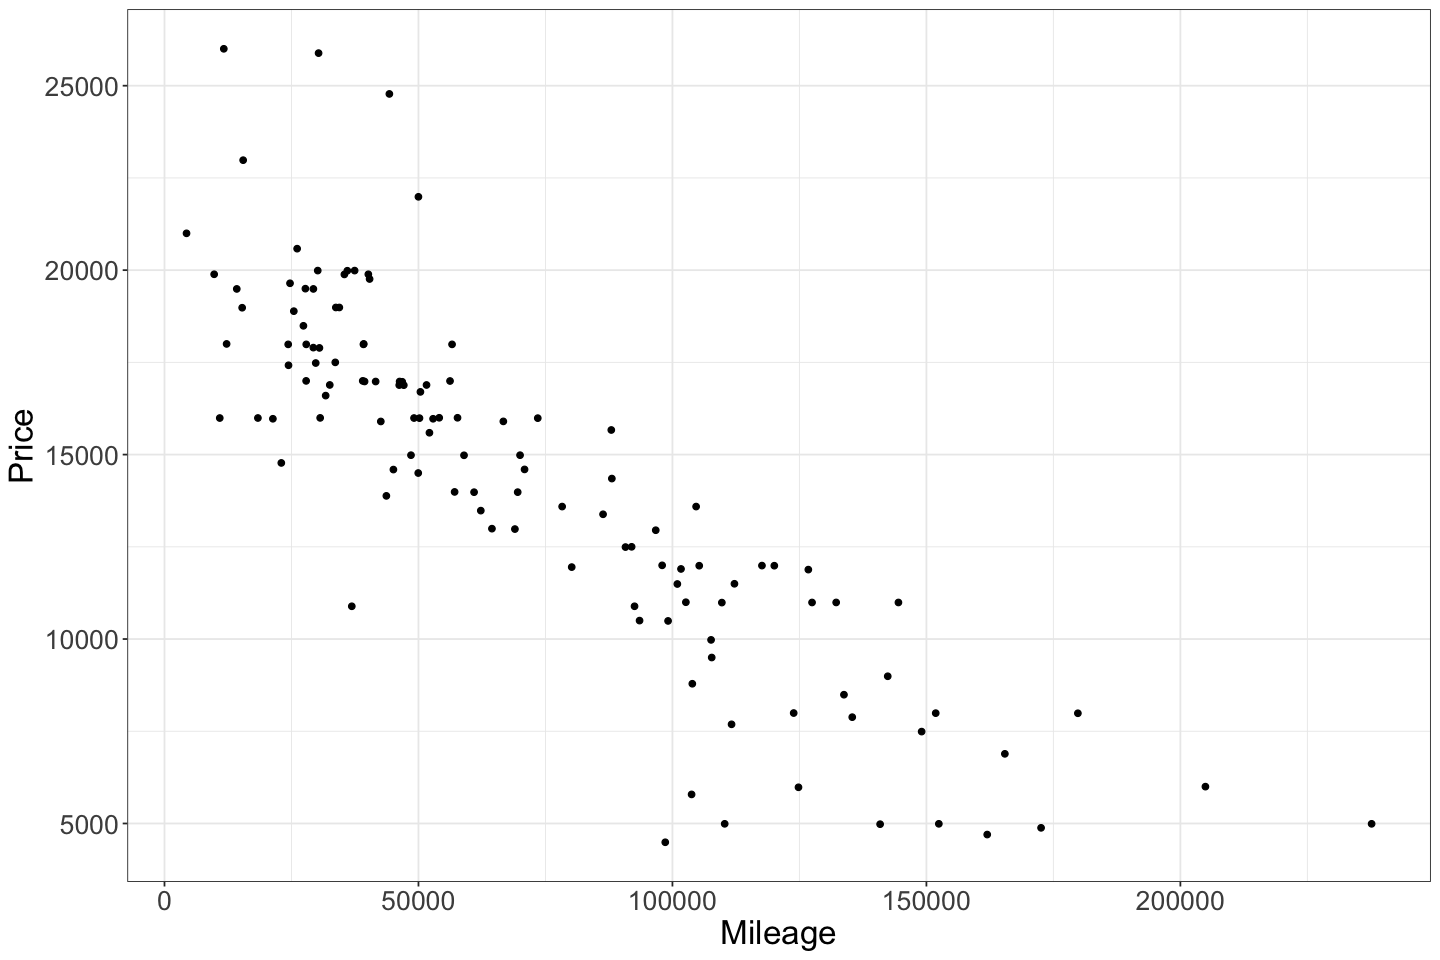

In [150]:
# Plot price as a function of mileage
ggplot(accords_data, aes(x = mileage, y = price)) +
  geom_point() +
  labs(x = "Mileage", y = "Price")

### Train/Test Error

Let's try fitting several linear regression models with different polynomial degrees, and plot the corresponding train/test RMSE.

In [151]:
# Split into train/test data
set.seed(5)

test_size = 0.2
train_indices = sample(1:nrow(accords_data), nrow(accords_data) * (1 - test_size))
train_data = accords_data[train_indices, ]
test_data = accords_data[-train_indices, ]

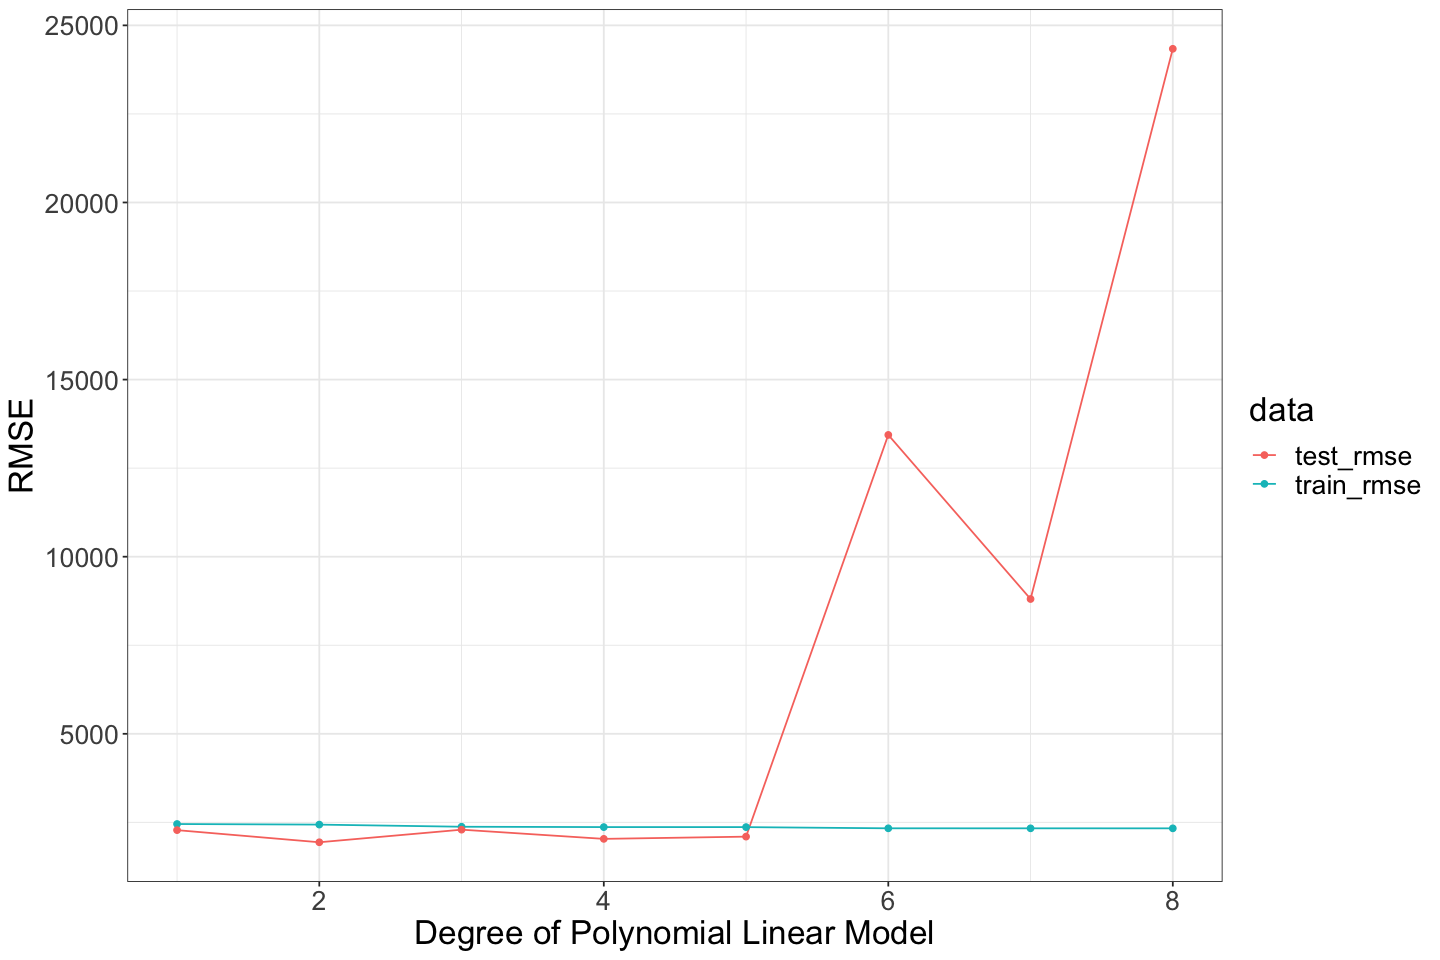

In [152]:
degrees = 1:8

train_rmses = numeric(length(degrees))
test_rmses = numeric(length(degrees))

for (degree in degrees) {
    model = lm(price ~ poly(mileage, degree), data = train_data)
    train_predictions = predict(model, train_data)
    test_predictions = predict(model, test_data)

    train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
    test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

    train_rmses[degree] = train_rmse
    test_rmses[degree] = test_rmse
}

errors = tibble(degree = degrees, train_rmse = train_rmses, test_rmse = test_rmses)
errors_long = gather(errors, "train_rmse", "test_rmse", key = "data", value = "rmse")

ggplot(errors_long, aes(x = degree, y = rmse, color = data)) +
  geom_line() +
  geom_point() +
  labs(x = "Degree of Polynomial Linear Model", y = "RMSE")

### Try Using a More Complex Model

A random forest is a more powerful machine learning model. Since it is more complex than a linear model, it is more likely to overfit!

<img src="img/rf.jpeg" alt= “spam-email” width="500" />

In [153]:
rf = randomForest(price ~ mileage, data = train_data, ntree = 1000)

train_predictions = predict(rf, train_data)
test_predictions = predict(rf, test_data)

train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

print(train_rmse)
print(test_rmse)

[1] 1353
[1] 2870


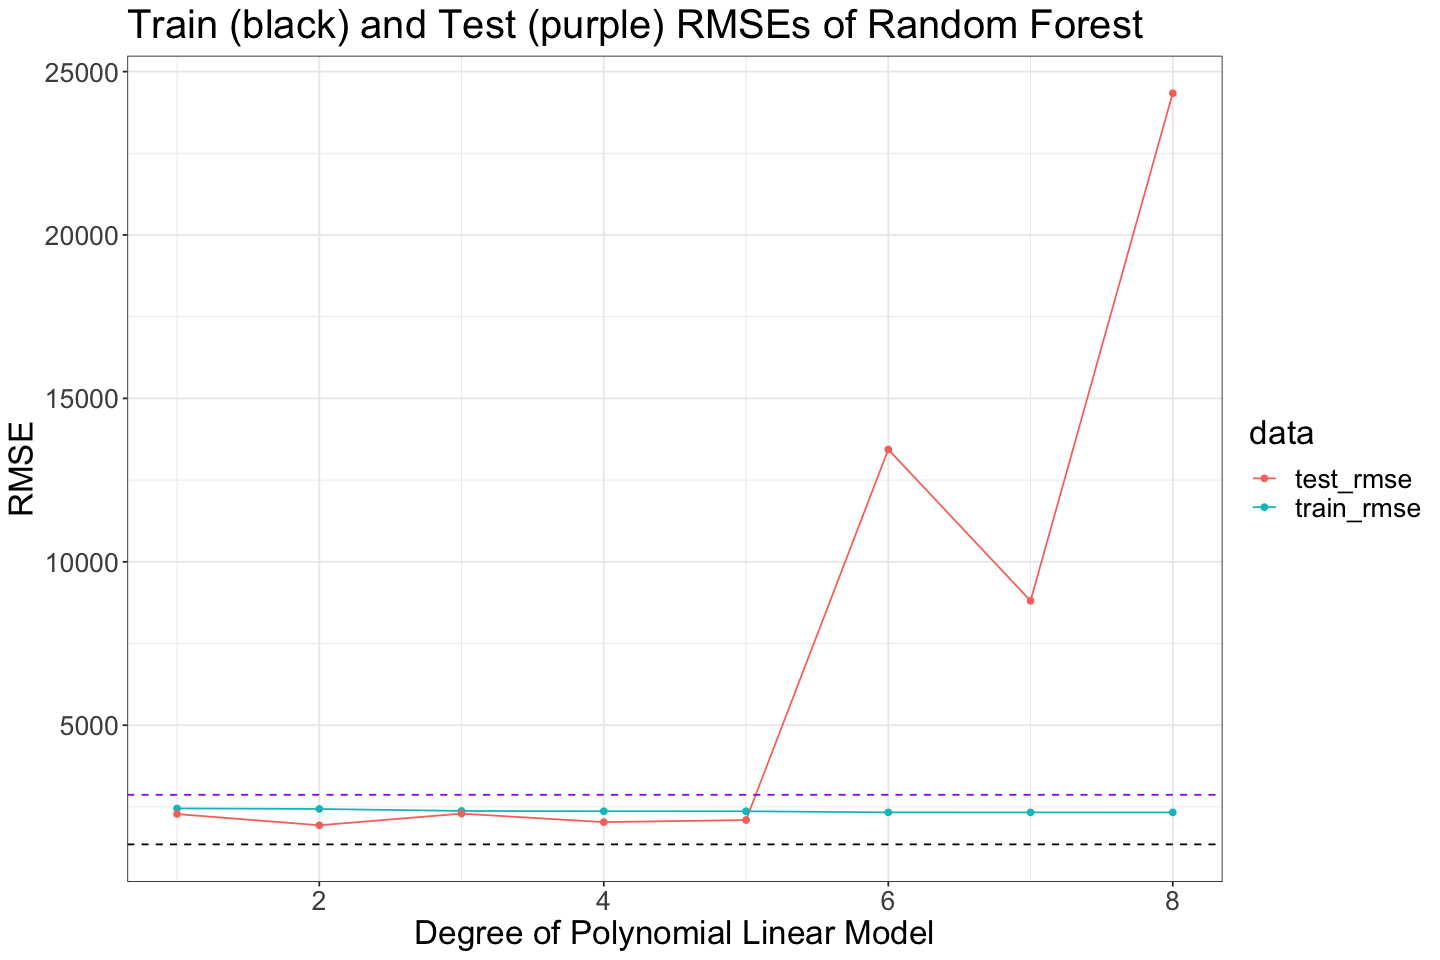

In [154]:
ggplot(errors_long, aes(x = degree, y = rmse, color = data)) +
    geom_line() +
    geom_point() +
    labs(x = "Degree of Polynomial Linear Model", y = "RMSE") + 
    # Add a horizontal line for the test RMSE of the random forest model
    geom_hline(yintercept = train_rmse, linetype = "dashed", color = "black") + 
    geom_hline(yintercept = test_rmse, linetype = "dashed", color = "purple") + 
    ggtitle("Train (black) and Test (purple) RMSEs of Random Forest")

### What changes if we use more data?

Let's use the entire cars dataset instead of just the accords data

In [155]:
set.seed(5)

test_size = 0.2
train_indices = sample(1:nrow(cars_data), nrow(cars_data) * (1 - test_size))
train_data = cars_data[train_indices, ]
test_data = cars_data[-train_indices, ]

rf = randomForest(price ~ mileage, data = train_data, ntree = 1000)

train_predictions = predict(rf, train_data)
test_predictions = predict(rf, test_data)

rf_train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
rf_test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

print(rf_train_rmse)
print(rf_test_rmse)

[1] 3551
[1] 7056


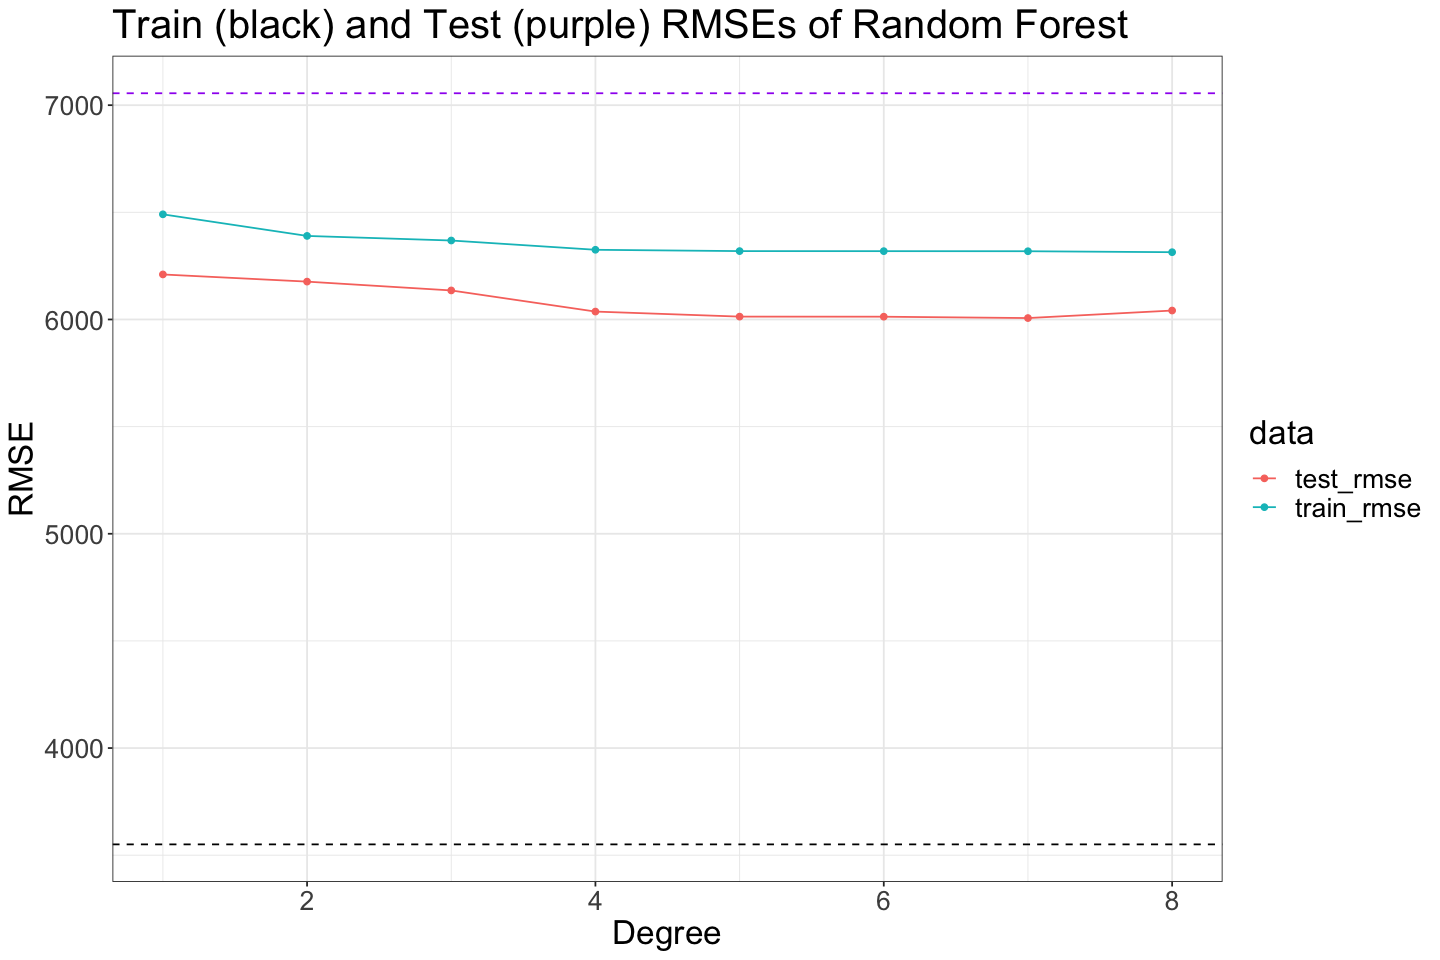

In [156]:
degrees = 1:8

train_rmses = numeric(length(degrees))
test_rmses = numeric(length(degrees))

for (degree in degrees) {
    model = lm(price ~ poly(mileage, degree), data = train_data)
    train_predictions = predict(model, train_data)
    test_predictions = predict(model, test_data)

    train_rmse = sqrt(mean((train_predictions - train_data$price)^2))
    test_rmse = sqrt(mean((test_predictions - test_data$price)^2))

    train_rmses[degree] = train_rmse
    test_rmses[degree] = test_rmse
}

errors = tibble(degree = degrees, train_rmse = train_rmses, test_rmse = test_rmses)
errors_long = gather(errors, "train_rmse", "test_rmse", key = "data", value = "rmse")

ggplot(errors_long, aes(x = degree, y = rmse, color = data)) +
  geom_line() +
  geom_point() +
  labs(x = "Degree", y = "RMSE") + 
  geom_hline(yintercept = rf_train_rmse, linetype = "dashed", color = "black") + 
  geom_hline(yintercept = rf_test_rmse, linetype = "dashed", color = "purple") + 
  ggtitle("Train (black) and Test (purple) RMSEs of Random Forest")
  


#### Takeaway

Random Forest is still overfitting, even worse than polynomial linear models!

If you want to use a more complex model, always check to make sure it is not overfitting!